In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability - including Apple Silicon (M1/M2/M3) support
if hasattr(torch, 'backends') and hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple Silicon GPU
    print(f"Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA GPU
    print(f"Using NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")  # Use CPU
    print(f"Using CPU")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")


Using Apple Silicon GPU (MPS)
PyTorch version: 2.2.1
Device: mps


In [3]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize with mean and std of MNIST
])

# Load MNIST train dataset
train_dataset = datasets.MNIST(
    root='./data',                # Directory where the dataset will be stored
    train=True,                   # This is training data
    download=True,                # Download if not already downloaded
    transform=transform           # Apply the defined transformations
)

# Load MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True                  # Shuffle training data for better learning
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False                 # No need to shuffle test data
)

# Print dataset information
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Image dimensions: {train_dataset[0][0].shape}")
print(f"Classes: {train_dataset.classes}")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:04<00:00, 2248647.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 144838.17it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 975727.40it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 958179.70it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training dataset size: 60000
Test dataset size: 10000
Number of classes: 10
Image dimensions: torch.Size([1, 28, 28])
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


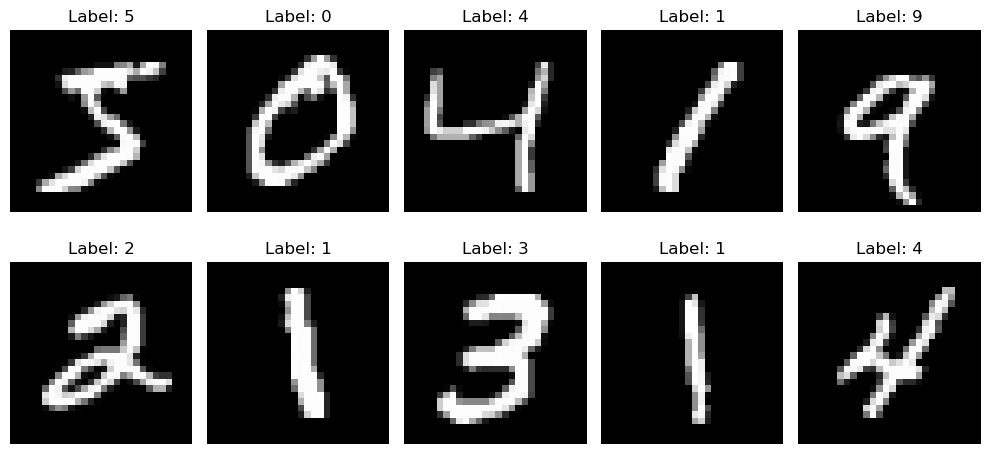

In [4]:
# Visualize some samples from the dataset
plt.figure(figsize=(10, 5))

for i in range(10):
    # Get a sample image
    img, label = train_dataset[i]
    
    # Convert tensor to numpy for visualization
    img = img.squeeze().numpy()
    
    # Create subplot
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for better convergence
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # Max pooling: reduces spatial dimensions by 2
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        # Calculate size after convolutions and pooling
        # Input: 28x28 -> After 3 pooling layers (each dividing by 2): 28/(2^3)=3.5 -> 3x3
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  # Fully connected layer
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(512, 10)  # Output layer (10 classes for digits 0-9)

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        # Second block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        # Third block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)  # Log softmax for NLL Loss

# Initialize the model
model = MNIST_CNN().to(device)
print(model)


MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define functions for training and testing
def train(model, device, train_loader, optimizer, criterion, epoch):
    """Train the model for one epoch"""
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # Print statistics every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx+1}/{len(train_loader)}, '
                  f'Loss: {running_loss/100:.4f}, '
                  f'Accuracy: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    return 100. * correct / total

def test(model, device, test_loader, criterion):
    """Test the model on the test set"""
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to track gradients
        for data, target in test_loader:
            # Move data to device
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Calculate loss
            test_loss += criterion(output, target).item()
            
            # Calculate accuracy
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    print(f'Test set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {test_accuracy:.2f}%')
    
    return test_accuracy


In [7]:
# Train the model
num_epochs = 5
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    print("-" * 50)
    
    # Train for one epoch
    train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    train_accuracies.append(train_accuracy)
    
    # Test after each epoch
    test_accuracy = test(model, device, test_loader, criterion)
    test_accuracies.append(test_accuracy)



Epoch 1/5
--------------------------------------------------
Epoch: 1, Batch: 100/938, Loss: 0.4609, Accuracy: 85.25%
Epoch: 1, Batch: 200/938, Loss: 0.1306, Accuracy: 90.47%
Epoch: 1, Batch: 300/938, Loss: 0.1088, Accuracy: 92.55%
Epoch: 1, Batch: 400/938, Loss: 0.0916, Accuracy: 93.73%
Epoch: 1, Batch: 500/938, Loss: 0.0858, Accuracy: 94.46%
Epoch: 1, Batch: 600/938, Loss: 0.0757, Accuracy: 94.98%
Epoch: 1, Batch: 700/938, Loss: 0.0662, Accuracy: 95.40%
Epoch: 1, Batch: 800/938, Loss: 0.0708, Accuracy: 95.70%
Epoch: 1, Batch: 900/938, Loss: 0.0650, Accuracy: 95.95%
Test set: Average loss: 0.0334, Accuracy: 98.86%

Epoch 2/5
--------------------------------------------------
Epoch: 2, Batch: 100/938, Loss: 0.0475, Accuracy: 98.61%
Epoch: 2, Batch: 200/938, Loss: 0.0547, Accuracy: 98.51%
Epoch: 2, Batch: 300/938, Loss: 0.0536, Accuracy: 98.42%
Epoch: 2, Batch: 400/938, Loss: 0.0459, Accuracy: 98.48%
Epoch: 2, Batch: 500/938, Loss: 0.0411, Accuracy: 98.50%
Epoch: 2, Batch: 600/938, Los

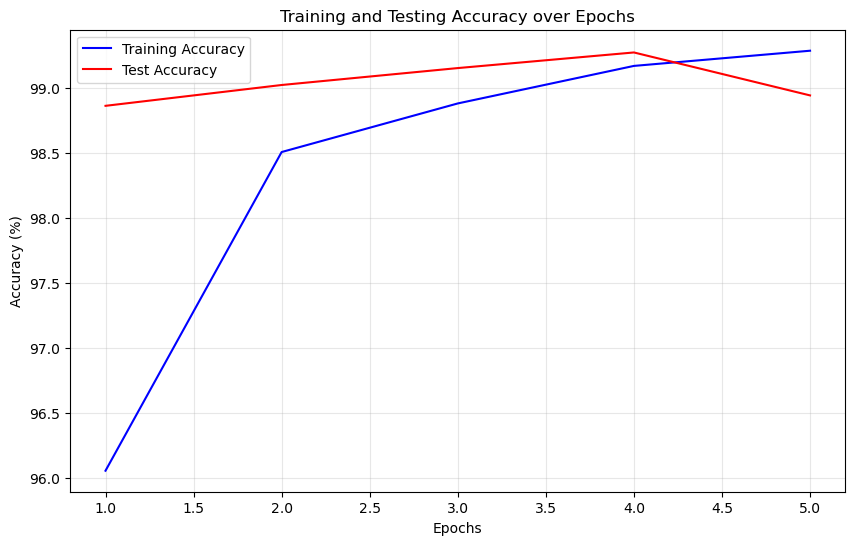

Model saved as 'mnist_cnn_model.pth'


In [8]:
# Plot the training and testing accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, 'r-', label='Test Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save the model
torch.save(model.state_dict(), 'mnist_cnn_model.pth')
print("Model saved as 'mnist_cnn_model.pth'")


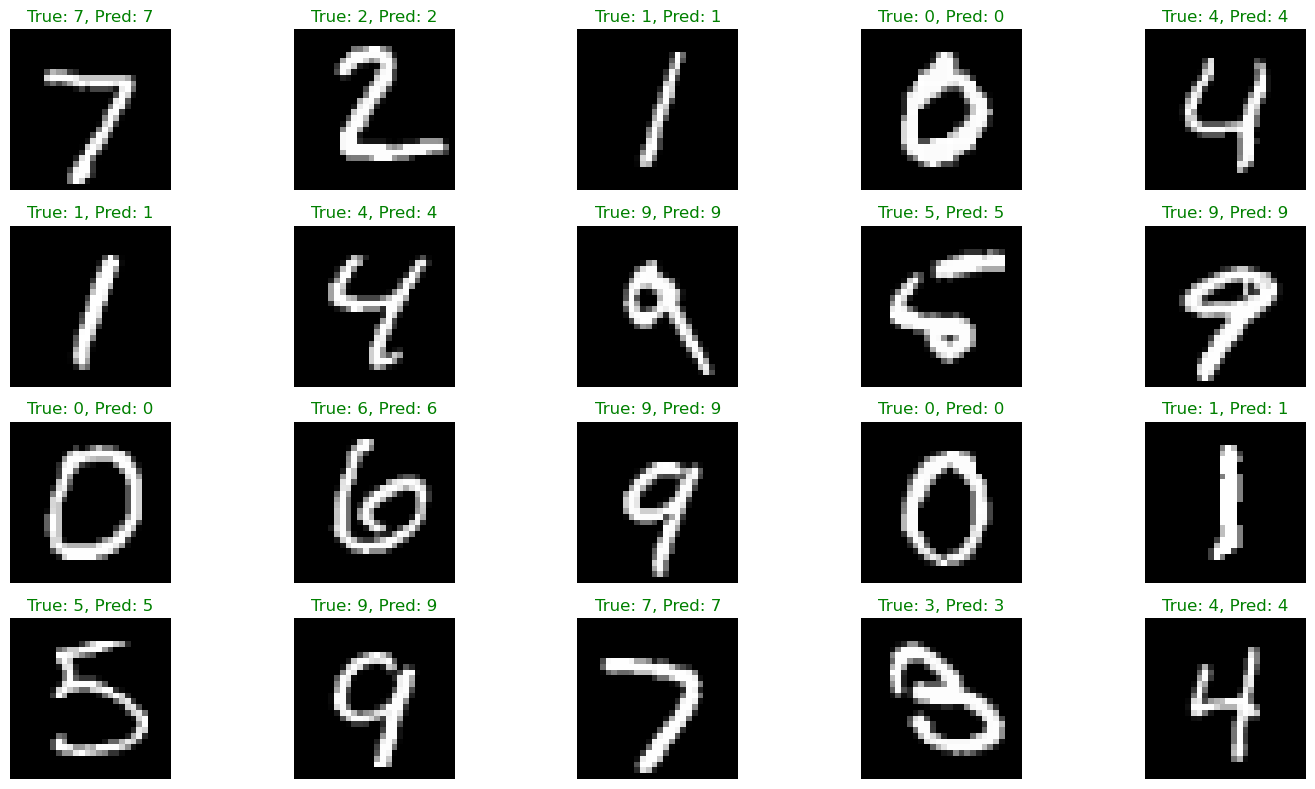

In [9]:
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move to device
images, labels = images.to(device), labels.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Move back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Plot some test images along with their predictions
plt.figure(figsize=(15, 8))

for i in range(20):  # Display 20 images
    plt.subplot(4, 5, i + 1)
    
    # Denormalize the image
    img = images[i].squeeze().numpy()
    
    plt.imshow(img, cmap='gray')
    
    # Set the title color based on prediction correctness
    if predicted[i] == labels[i]:
        title_color = 'green'
    else:
        title_color = 'red'
    
    plt.title(f'True: {labels[i]}, Pred: {predicted[i]}', 
              color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()


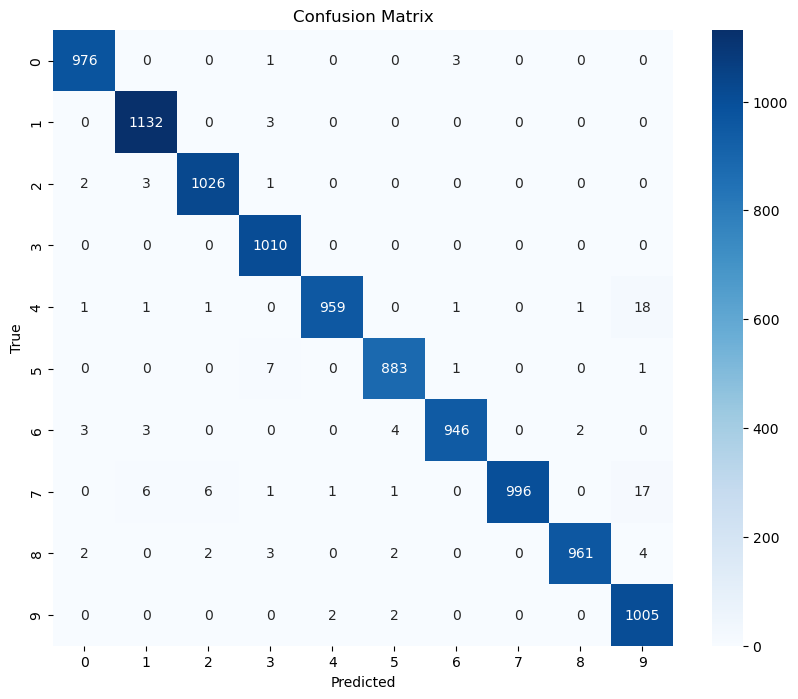

              precision    recall  f1-score   support

           0     0.9919    0.9959    0.9939       980
           1     0.9886    0.9974    0.9930      1135
           2     0.9913    0.9942    0.9927      1032
           3     0.9844    1.0000    0.9921      1010
           4     0.9969    0.9766    0.9866       982
           5     0.9899    0.9899    0.9899       892
           6     0.9947    0.9875    0.9911       958
           7     1.0000    0.9689    0.9842      1028
           8     0.9969    0.9867    0.9917       974
           9     0.9617    0.9960    0.9786      1009

    accuracy                         0.9894     10000
   macro avg     0.9896    0.9893    0.9894     10000
weighted avg     0.9896    0.9894    0.9894     10000



In [10]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the entire test set
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print classification metrics
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, digits=4))


True label: 1


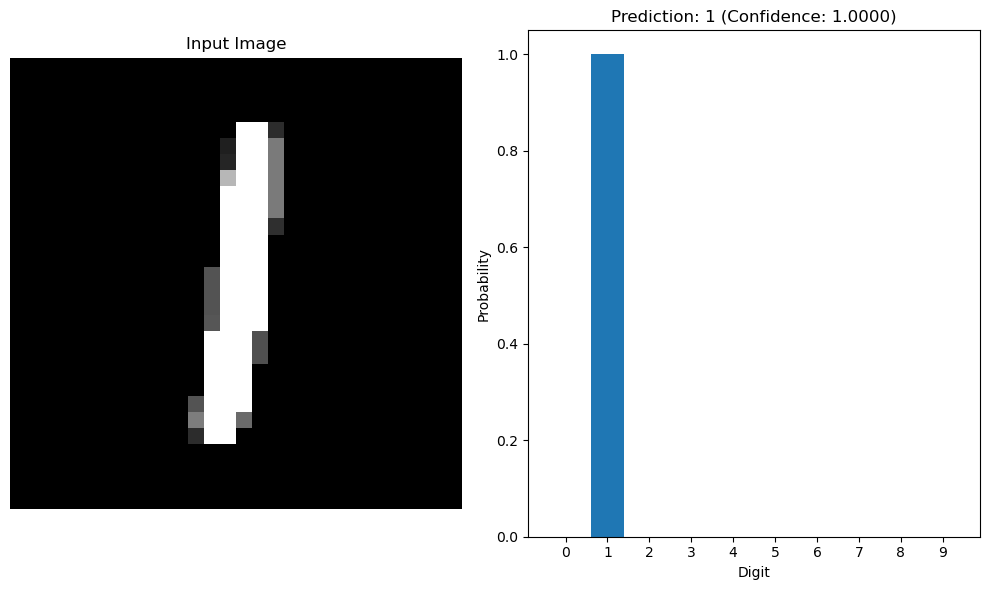

Predicted: 1


In [11]:
def predict_digit(image_path=None, image=None):
    """
    Predict the digit from an image.
    Args:
        image_path: Path to the image file
        image: Alternatively, provide a PIL Image or numpy array directly
    Returns:
        Predicted digit
    """
    from PIL import Image
    import torchvision.transforms.functional as TF
    
    if image_path is not None:
        # Load image from path
        img = Image.open(image_path).convert('L')  # Convert to grayscale
    elif image is not None:
        # Use provided image
        if isinstance(image, np.ndarray):
            img = Image.fromarray(image)
        else:
            img = image
    else:
        raise ValueError("Either image_path or image must be provided")
    
    # Resize to 28x28
    img = img.resize((28, 28))
    
    # Convert to tensor and normalize
    img_tensor = TF.to_tensor(img)
    img_tensor = TF.normalize(img_tensor, (0.1307,), (0.3081,))
    img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension
    
    # Make prediction
    with torch.no_grad():
        model.eval()
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
        
    # Get prediction probabilities
    probabilities = torch.exp(output).cpu().numpy()[0]
    
    # Plot the image and prediction
    plt.figure(figsize=(10, 6))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    # Prediction probabilities
    plt.subplot(1, 2, 2)
    plt.bar(range(10), probabilities)
    plt.xticks(range(10))
    plt.xlabel('Digit')
    plt.ylabel('Probability')
    plt.title(f'Prediction: {predicted.item()} (Confidence: {probabilities[predicted.item()]:.4f})')
    
    plt.tight_layout()
    plt.show()
    
    return predicted.item()

# Example of how to use the function:
# predict_digit('path_to_your_digit_image.png')

# If you want to test with a random test set image:
# Get a random test image
idx = np.random.randint(0, len(test_dataset))
img, label = test_dataset[idx]
img_np = img.squeeze().numpy()

print(f"True label: {label}")
predicted = predict_digit(image=img_np * 255)  # Scale back to 0-255 range
print(f"Predicted: {predicted}")
